1. SIFT Image-based Object Detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from google.colab import files

def detect_object(query_img, target_img):
    """
    Detect an object from a query image in a target image using SIFT features and FLANN matcher.

    Args:
        query_img: Query image containing the object to detect
        target_img: Target image where we want to find the object

    Returns:
        Displayed image with matched points drawn
    """
    # Convert images to grayscale for feature detection
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors with SIFT
    query_keypoints, query_descriptors = sift.detectAndCompute(query_gray, None)
    target_keypoints, target_descriptors = sift.detectAndCompute(target_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary

    # Use FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(query_descriptors, target_descriptors, k=2)

    # Apply ratio test to get good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:  # Lowe's ratio test
            good_matches.append(m)

    # Extract location of good matches
    if len(good_matches) >= 4:
        query_points = np.float32([query_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        target_points = np.float32([target_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Find homography
        M, mask = cv2.findHomography(query_points, target_points, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # Height and width of query image
        h, w = query_gray.shape

        # Define corners of the query image
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

        # Transform corners to target image coordinates
        dst = cv2.perspectiveTransform(pts, M)

        # Draw the outline of the query object in the target image
        target_with_outline = target_img.copy()
        cv2.polylines(target_with_outline, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Draw all the good matches on the target image
        target_with_points = target_img.copy()
        for i, point in enumerate(target_points):
            if matchesMask[i]:
                # Extract the coordinates from the point
                x, y = point[0]
                # Draw a circle at each matched point
                cv2.circle(target_with_points, (int(x), int(y)), 5, (0, 0, 255), -1)

        # Return results
        return {
            'target_with_outline': target_with_outline,
            'target_with_points': target_with_points,
            'good_matches': len(good_matches),
            'query_keypoints': len(query_keypoints),
            'target_keypoints': len(target_keypoints)
        }
    else:
        print("Not enough good matches found - {}/{}".format(len(good_matches), 4))
        return None

def visualize_results(results, query_img, target_img):
    """
    Visualize the results of object detection

    Args:
        results: Dictionary containing results from detect_object function
        query_img: Original query image
        target_img: Original target image
    """
    if results is None:
        print("No results to visualize")
        return

    # Create figure with 4 subplots
    fig, ax = plt.subplots(2, 2, figsize=(15, 12))

    # Display the query image
    ax[0, 0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    ax[0, 0].set_title('Query Image')
    ax[0, 0].axis('off')

    # Display the target image
    ax[0, 1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
    ax[0, 1].set_title('Target Image')
    ax[0, 1].axis('off')

    # Display the target image with outline
    ax[1, 0].imshow(cv2.cvtColor(results['target_with_outline'], cv2.COLOR_BGR2RGB))
    ax[1, 0].set_title('Object Outline')
    ax[1, 0].axis('off')

    # Display the target image with matched points
    ax[1, 1].imshow(cv2.cvtColor(results['target_with_points'], cv2.COLOR_BGR2RGB))
    ax[1, 1].set_title('Matched Points')
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.suptitle(f"Found {results['good_matches']} good matches out of {results['query_keypoints']} query keypoints", y=0.98)
    plt.show()

2. File Upload and Processing

In [ ]:
# Function to upload and process images
def upload_and_process_images():
    print("Upload your query image (the object you want to detect):")
    uploaded_query = files.upload()
    query_filename = next(iter(uploaded_query))
    query_img = cv2.imdecode(np.frombuffer(uploaded_query[query_filename], np.uint8), cv2.IMREAD_COLOR)

    print("\nUpload your target image (where you want to find the object):")
    uploaded_target = files.upload()
    target_filename = next(iter(uploaded_target))
    target_img = cv2.imdecode(np.frombuffer(uploaded_target[target_filename], np.uint8), cv2.IMREAD_COLOR)

    # Display SIFT keypoints on query image
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    query_keypoints = sift.detect(query_gray, None)
    img_keypoints = cv2.drawKeypoints(query_img, query_keypoints, None,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Query Image with {len(query_keypoints)} SIFT Keypoints")
    plt.axis('off')
    plt.show()

    # Detect object
    print("Detecting object in target image...")
    results = detect_object(query_img, target_img)

    # Display results
    visualize_results(results, query_img, target_img)

3. Video Object Detection (Bonus)

In [ ]:
def detect_object_in_uploaded_video(query_img):
    """
    Detect an object from a query image in each frame of an uploaded video using SIFT features.

    Args:
        query_img: Query image containing the object to detect
    """
    print("Upload your video file:")
    uploaded_video = files.upload()
    video_filename = next(iter(uploaded_video))

    # Save the uploaded video to a temporary file
    with open('/tmp/temp_video.mp4', 'wb') as f:
        f.write(uploaded_video[video_filename])

    # Convert query image to grayscale
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find keypoints and descriptors with SIFT for the query image
    query_keypoints, query_descriptors = sift.detectAndCompute(query_gray, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # Use FLANN matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Initialize video capture
    cap = cv2.VideoCapture('/tmp/temp_video.mp4')

    if not cap.isOpened():
        print("Error: Could not open video source")
        return

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer for output
    output_video = cv2.VideoWriter('/tmp/output_video.mp4',
                                  cv2.VideoWriter_fourcc(*'mp4v'),
                                  fps, (width, height))

    # Process frames
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    processed_frames = []

    from tqdm.notebook import tqdm

    for _ in tqdm(range(total_frames), desc="Processing video frames"):
        # Read frame
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Process every 5th frame to speed up processing
        if frame_count % 5 != 0 and frame_count != 1:
            output_video.write(frame)
            continue

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Find descriptors for the frame
        frame_keypoints, frame_descriptors = sift.detectAndCompute(frame_gray, None)

        # Save a sample frame for display
        if frame_count == 1:
            sample_frame = frame.copy()

        if frame_descriptors is not None and len(frame_descriptors) > 0:
            # Match descriptors
            matches = flann.knnMatch(query_descriptors, frame_descriptors, k=2)

            # Apply ratio test
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # If enough good matches are found, find the object
            if len(good_matches) >= 10:
                # Extract location of good matches
                query_points = np.float32([query_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                frame_points = np.float32([frame_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                # Find homography
                M, mask = cv2.findHomography(query_points, frame_points, cv2.RANSAC, 5.0)

                if M is not None:
                    # Height and width of query image
                    h, w = query_gray.shape

                    # Define corners of the query image
                    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

                    # Transform corners to frame coordinates
                    dst = cv2.perspectiveTransform(pts, M)

                    # Draw rectangle around the object
                    frame = cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

                    # Display text showing the number of good matches
                    cv2.putText(frame, f"Matches: {len(good_matches)}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                    # Save processed frame for display
                    if len(processed_frames) < 3 and frame_count % 30 == 0:
                        processed_frames.append(frame.copy())

        # Write the frame to output video
        output_video.write(frame)

    # Release resources
    cap.release()
    output_video.release()

    # Display sample frames
    fig, ax = plt.subplots(1, min(len(processed_frames) + 1, 4), figsize=(20, 5))

    # Display the query image
    ax[0].imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Query Image')
    ax[0].axis('off')

    # Display sample processed frames
    for i, processed_frame in enumerate(processed_frames):
        if i < 3:  # Only show up to 3 processed frames
            ax[i+1].imshow(cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB))
            ax[i+1].set_title(f'Processed Frame {i+1}')
            ax[i+1].axis('off')

    plt.tight_layout()
    plt.show()

    # Convert the output video to a format suitable for display in Colab
    from IPython.display import HTML
    from base64 import b64encode

    mp4 = open('/tmp/output_video.mp4', 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    print("Processed video:")
    return HTML(f"""
    <video width=500 controls>
        <source src="{data_url}" type="video/mp4">
    </video>
    """)

Usage Section

SIFT Object Detection Implementation
This notebook implements the Scale-Invariant Feature Transform (SIFT) algorithm
for object detection using OpenCV.

Options:
1. Detect an object in a target image
2. Detect an object in a video (Bonus)

Enter your choice (1 or 2): 2
Upload your query image (the object you want to detect):


Saving image_2025-04-19_214753519.png to image_2025-04-19_214753519.png


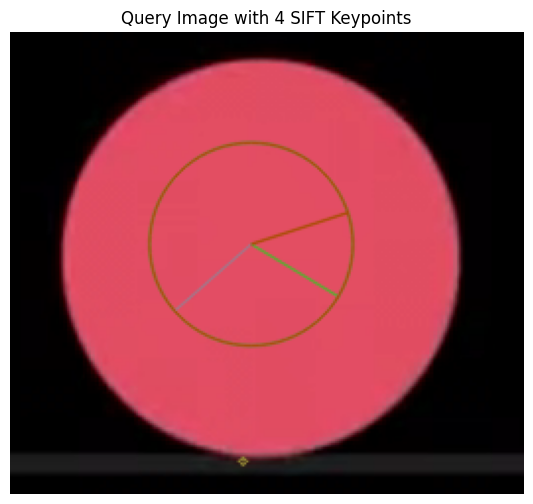

Upload your video file:


Saving vecteezy_cube-circle-and-triangle-motion-elements-jumping-on-alpha_36436696.mov to vecteezy_cube-circle-and-triangle-motion-elements-jumping-on-alpha_36436696.mov


Processing video frames:   0%|          | 0/210 [00:00<?, ?it/s]

TypeError: 'Axes' object is not subscriptable

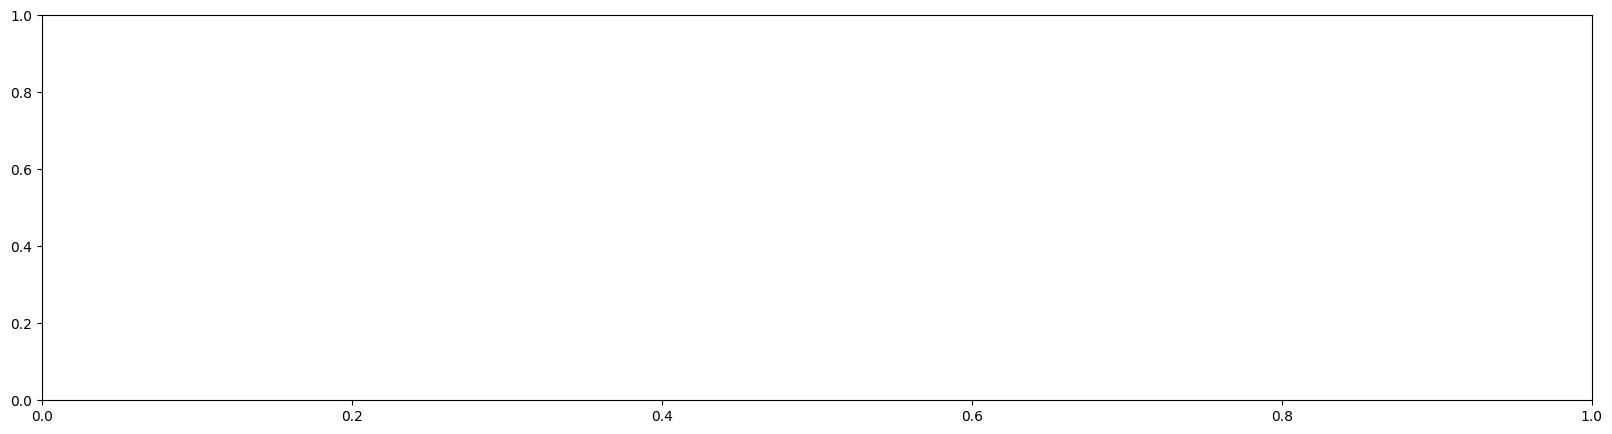

In [7]:
# Main execution block
print("SIFT Object Detection Implementation")
print("===================================")
print("This notebook implements the Scale-Invariant Feature Transform (SIFT) algorithm")
print("for object detection using OpenCV.")
print("\nOptions:")
print("1. Detect an object in a target image")
print("2. Detect an object in a video (Bonus)")

choice = input("\nEnter your choice (1 or 2): ")

if choice == '1':
    upload_and_process_images()
elif choice == '2':
    print("Upload your query image (the object you want to detect):")
    uploaded_query = files.upload()
    query_filename = next(iter(uploaded_query))
    query_img = cv2.imdecode(np.frombuffer(uploaded_query[query_filename], np.uint8), cv2.IMREAD_COLOR)

    # Display keypoints on query image
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    query_keypoints = sift.detect(query_gray, None)
    img_keypoints = cv2.drawKeypoints(query_img, query_keypoints, None,
                                     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
    plt.title(f"Query Image with {len(query_keypoints)} SIFT Keypoints")
    plt.axis('off')
    plt.show()

    display(detect_object_in_uploaded_video(query_img))
else:
    print("Invalid choice. Please run the cell again and select 1 or 2.")